In [2]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [3]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.analyzefx as afx
from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

## Global Params

In [265]:
parentDir = 'cbgtDemoTEST21f'


savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [31]:
def get_sampling_params(scale=.05):
    
#     CxSTR      =    0.2*.7 # overrides value in netgen.py, but is also partially overridden by dpmn_w
#     CxTh       =    0.03*.1
#     CxFSI      =    0.165
#     D1STR_GPi  =    1.10*1.5 #1.07
#     D2STR_GPeP =    1.65
#     STN_GPeP_A =    0.07
#     STN_GPeP_N =    4.01
#     STN_GPi    =    0.0324
#     GPi_Th     =    0.067*0.8
#     ThSTR      =    0.34*1.5
#     ThCx       =    0.02
    
    CxSTR      =    0.2*.7*.9
    CxTh       =    0.03
    CxFSI      =    0.165*.8
    D1STR_GPi  =    1.10 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34*.75
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

# Sample 3 individual networks

In [32]:
N_subj = 3
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Simulate example trial

In [33]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5
# get preset for "high" reward condition
# (e.g., Cx-dMSN weight scalars)
preset = presetDict['no']

# set save directory
ng.setDirectory(saveTest)

# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               #dpmn_ratio=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                               #dpmn_implied=[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25],
                               seed=list(range(0,250)),
                               d1aw=[55],
                               d2aw=[-45],
                               #rewardprob=[0.65,0.75,0.85],
                               rewardprob=[1.0],
                               #dpmn_implied=[4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625]
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7
                              )
sweepcount

250

In [34]:
# compile current configuration and simulate trial
ng.compileAndRunSweepALL(1, 0, sweepcount, 23)

In [231]:
ng.compileAndRunSweepALL(1, 0, 23, 23)

In [119]:
50*3

150

# Plot population firing rates

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


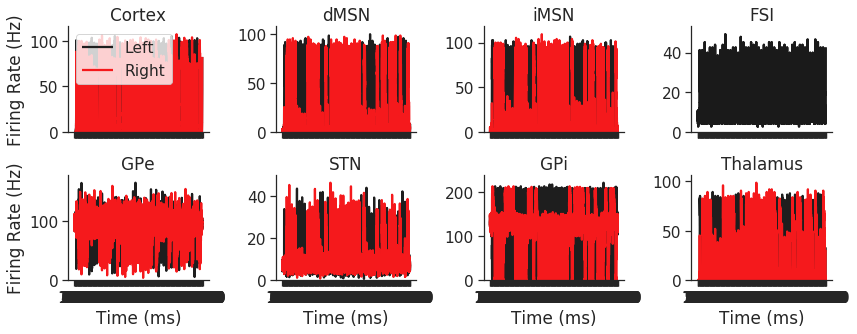

In [9]:
vis.plot_trial_rates(t=0)

In [267]:
parentDir = 'cbgtDemoTEST21f'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [6]:
results = ng.readAllTrialResults(1,0,250,['popfreqs']) # ,'popQ1s','popQ2s','dopamine', 'popEs'
#results = ng.readAllTrialResults(3,0,176,['popfreqs'])
decisions = []
for sn in range(250):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])
#decisions

In [268]:
resultsB = ng.readAllTrialResults(1,0,5,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs']) # 
#results = ng.readAllTrialResults(3,0,176,['popfreqs'])
decisionsB = []
for sn in range(5):
    decisionsB.append([])
    for result in resultsB[sn]:
        decisionsB[sn].append(ng.findOutputs2(result)['decision made'])
#decisions

0.7
0.5
1.0
-45
55
0


(0, 100)

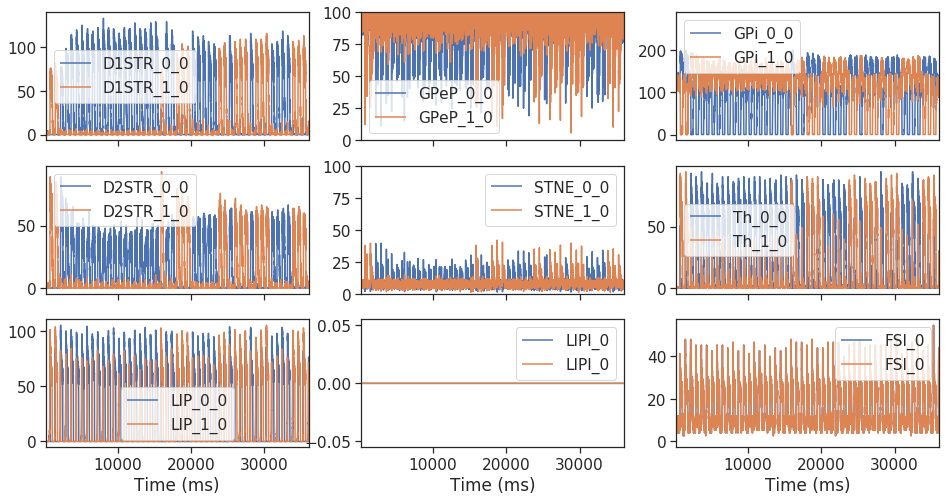

In [14]:
result = results[0][0]
print(result['dpmn_implied'])
print(result['dpmn_ratio'])
print(result['rewardprob'])  # %3
print(result['d2aw'])  # %18
print(result['d1aw']) # %108
print(result['seed'])

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1[0])
    result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax1[1])
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2[0])
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    result['popfreqs'].plot(x='Time (ms)', y='FSI'+'_0', ax=ax3[2])

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(200, ax.get_xlim()[-1])#(750,900)#
    axx.set_xlim(200, axx.get_xlim()[-1])#(750,900)#
    axxx.set_xlim(200, axxx.get_xlim()[-1])#(750,900)#

ax2[1].set_ylim(0,100)
ax1[1].set_ylim(0,100)

#plt.savefig('FR_ramping.png', dpi=400)

In [94]:
stagecount = 40

resultgrid4d = [[[[None for j in range(10)] for i in range(6)] for i in range(6)] for i in range(3)]
trialgrid4d = [[[[0 for j in range(stagecount)] for i in range(6)] for i in range(6)] for i in range(3)]

for sn in range(0,1080):
    resid = sn
    prob = resid % 3
    resid = (resid - prob) // 3
    d2aw = resid % 6
    resid = (resid - d2aw) // 6
    d1aw = resid % 6
    resid = (resid - d1aw) // 6
    seed = resid % 10
    
    #print(prob,d2aw,d1aw,seed)
    resultgrid4d[prob][d2aw][d1aw][seed] = results[sn][0]
    
    if len(decisions[sn][0]) != stagecount :
        print(len(decisions[sn][0]))
    
    for i in range(0, stagecount):
        if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
            if decisions[sn][0][i]['pathvals'][0] == 0:
                trialgrid4d[prob][d2aw][d1aw][i] += 1.0 / 10

In [233]:
stagecount = 40

resultgrid4d = [[None for j in range(50)] for i in range(3)]
trialgrid4d = [[0 for j in range(stagecount)] for i in range(3)]
#weightgrid4d = [[0 for j in range(stagecount)] for i in range(3)]
trialgrid4d_denom = [[0 for j in range(stagecount)] for i in range(3)]

for sn in range(0,150):
    resid = sn
    prob = resid % 3
    resid = (resid - prob) // 3
    seed = resid % 50
    
    #print(prob,d2aw,d1aw,seed)
    resultgrid4d[prob][seed] = results[sn][0]
    
    if len(decisions[sn][0]) != stagecount :
        print(len(decisions[sn][0]),prob)
    else:
        for i in range(0, stagecount):
            #weightgrid4d[prob][i] += 
            if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
                if decisions[sn][0][i]['pathvals'][0] == 0:
                    trialgrid4d[prob][i] += 1.0
                trialgrid4d_denom[prob][i] += 1.0

In [11]:
stagecount = 50

resultgrid4d = [[None for j in range(250)] for i in range(1)]
trialgrid4d = [[0 for j in range(stagecount)] for i in range(1)]
#weightgrid4d = [[0 for j in range(stagecount)] for i in range(3)]
trialgrid4d_denom = [[0 for j in range(stagecount)] for i in range(1)]

for sn in range(0,250):
    resid = sn
    prob = resid % 1
    resid = (resid - prob) // 1
    seed = resid % 250
    
    #print(prob,d2aw,d1aw,seed)
    resultgrid4d[prob][seed] = results[sn][0]
    
    if len(decisions[sn][0]) != stagecount :
        print(len(decisions[sn][0]),prob)
    else:
        for i in range(0, stagecount):
            #weightgrid4d[prob][i] += 
            if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
                if decisions[sn][0][i]['pathvals'][0] == 0:
                    trialgrid4d[prob][i] += 1.0

In [40]:
decisiondata = pd.DataFrame(columns=['sim','trial','decision'])
simcount = 250
stagecount = 50
j = 0
for sn in range(0,simcount):
    for i in range(0, stagecount):
        dec = 0.5
        if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
            if decisions[sn][0][i]['pathvals'][0] == 0:
                dec = 1
            if decisions[sn][0][i]['pathvals'][0] == 1:
                dec = 0
        decisiondata.loc[j] = [sn, i+1, dec]
        j += 1

decisiondata["sim"] = pd.to_numeric(decisiondata["sim"])
decisiondata["trial"] = pd.to_numeric(decisiondata["trial"])
decisiondata["decision"] = pd.to_numeric(decisiondata["decision"])

In [41]:
decisiondata


,sim,trial,decision
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,1
4,0,5,1
...,...,...,...
12495,249,46,0
12496,249,47,0
12497,249,48,1
12498,249,49,0


In [39]:
decisiondata.dtypes
decisiondata.dtypes

sim         int64
trial       int64
decision    int64
dtype: object

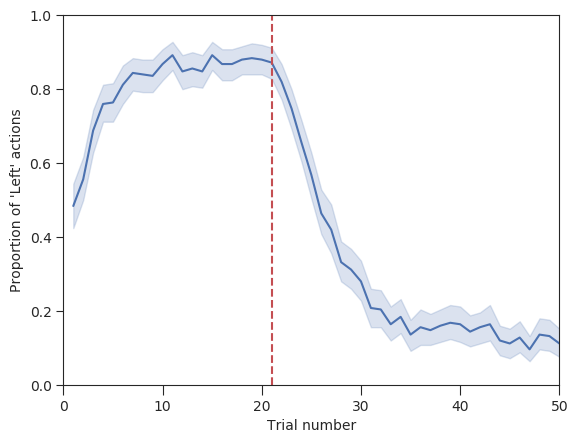

In [284]:
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
ax = sns.lineplot(x="trial", y="decision", data=decisiondata, ci=95)
ax.set_facecolor('w')
ax.set_ylabel("Proportion of 'Left' actions")
ax.set_xlabel("Trial number")
ax.set_ylim(0,1)
ax.set_xlim(0,50)
ax.axvline(21, color='r', linestyle='--')
plt.savefig("fig1.svg")

(0, 50)

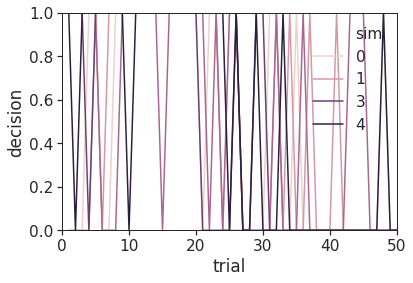

In [71]:
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
ax = sns.lineplot(x="trial", y="decision", units="sim", hue = "sim", data=decisiondata[decisiondata['sim']<5], estimator=None)
ax.set_ylim(0,1)
ax.set_xlim(0,50)

In [104]:
sum(trialgrid4d[2][5][5])

26.500000000000007

In [11]:
[i/250 for i in trialgrid4d[0]]

[0.512,
 0.612,
 0.732,
 0.768,
 0.924,
 0.904,
 0.932,
 0.904,
 0.94,
 0.948,
 0.912,
 0.94,
 0.964,
 0.972,
 0.964,
 0.948,
 0.94,
 0.944,
 0.944,
 0.928,
 0.952,
 0.936,
 0.896,
 0.84,
 0.812,
 0.82,
 0.824,
 0.804,
 0.788,
 0.744,
 0.776,
 0.784,
 0.716,
 0.712,
 0.744,
 0.676,
 0.696,
 0.644,
 0.592,
 0.652,
 0.656,
 0.636,
 0.596,
 0.636,
 0.628,
 0.664,
 0.68,
 0.596,
 0.568,
 0.64]

In [12]:
import math
err = 2.64 * math.sqrt(1) 
err

err = [[1.96*math.sqrt(trialgrid4d[p][s]/250*(1-trialgrid4d[p][s]/250)/250) for s in range(0,stagecount)] for p in range(0,1)]

IndexError: list index out of range

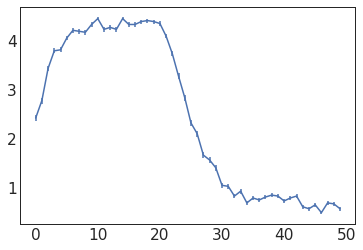

In [58]:
plt.figure()
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[0]], xerr=0, yerr=err[0])
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[1]], xerr=0, yerr=err[1])
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[2]], xerr=0, yerr=err[2])
plt.title("stuff")

Text(0.5, 1.0, '250 switch case sims (20+30 deterministic)')

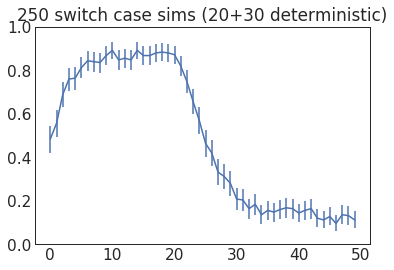

In [19]:
plt.figure()
plt.errorbar(list(range(stagecount)), [i/250 for i in trialgrid4d[0]], xerr=0, yerr=err[0])
plt.ylim(0.0,1)
plt.title("250 switch case sims (20+30 deterministic)")

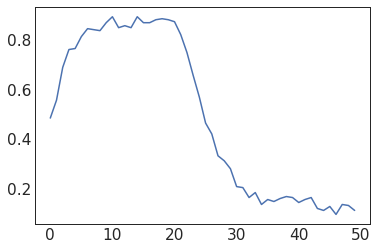

In [23]:
fig, (ax1) = plt.subplots(1, 1, sharex=True)
ax1.plot(list(range(stagecount)),[i/250 for i in trialgrid4d[0]])
plt.fill_between(x, y-error, y+error)

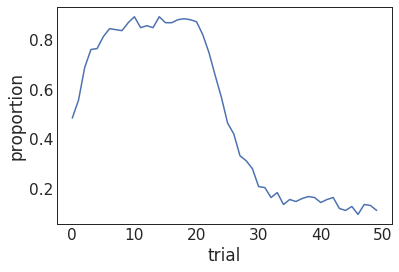

In [27]:
xs = list(range(stagecount))
ys = [i/250 for i in trialgrid4d[0]]
df = pd.DataFrame(list(zip(xs,ys)), columns=['trial','proportion'])
sns.lineplot(x='trial',y='proportion',data=df,err_style="bars")

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


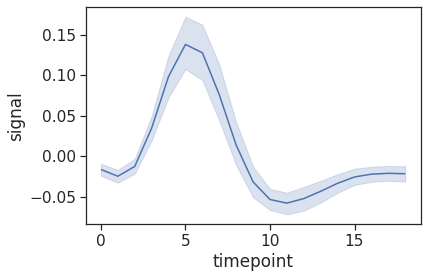

In [16]:
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="timepoint", y="signal", data=fmri)
fmri

In [14]:
err[0]

[0.061948899922436074,
 0.06159067274839592,
 0.05743248173638329,
 0.052941773298596645,
 0.05263671138663585,
 0.04843318241040949,
 0.044980014335257834,
 0.04544495747605008,
 0.045899835572690235,
 0.041959750313842435,
 0.03847515445583032,
 0.04450469070109352,
 0.04352153409060853,
 0.04450469070109352,
 0.03847515445583032,
 0.041959750313842435,
 0.041959750313842435,
 0.040282649366693846,
 0.03969549245947202,
 0.040282649366693846,
 0.04141420169941708,
 0.047624370232056616,
 0.05381918741861493,
 0.058886698749378026,
 0.061404769899414166,
 0.06181977956609034,
 0.06118214641543725,
 0.05837721067677009,
 0.05743248173638328,
 0.055658478599401186,
 0.05031301293303751,
 0.04995255246331263,
 0.045899835572690235,
 0.04803303822995168,
 0.0424925107001222,
 0.044980014335257834,
 0.04401865030188908,
 0.045444957476050075,
 0.04634494499295473,
 0.045899835572690235,
 0.04352153409060852,
 0.044980014335257834,
 0.045899835572690235,
 0.040282649366693846,
 0.0390932305

Text(0.5, 1.0, 'average timecourses (50 sims of each)')

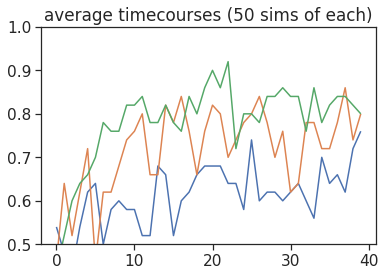

In [236]:
plt.figure()
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[0]], xerr=0, yerr=0)
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[1]], xerr=0, yerr=0)
plt.errorbar(list(range(stagecount)), [i/50 for i in trialgrid4d[2]], xerr=0, yerr=0)
plt.ylim(0.5,1)
plt.title("average timecourses (50 sims of each)")

In [237]:
ps = [sum(trialgrid4d[i][20:40])/20/50 for i in range(0,3)]
errs = [1.96*math.sqrt(ps[i]*(1-ps[i])/50/20) for i in range(0,3)]
ps

[0.6459999999999999, 0.758, 0.826]

Text(0, 0.5, "asymptotic 'left' actions")

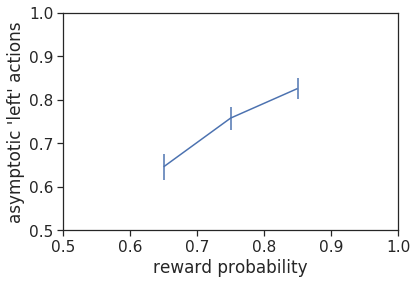

In [238]:
plt.figure()
plt.errorbar([0.65,0.75,0.85], ps, xerr=0, yerr=errs)
plt.ylim(0.5,1)
plt.xlim(0.5,1)
#plt.title("reward probability -> long term % of left actions")
plt.xlabel("reward probability")
plt.ylabel("asymptotic 'left' actions")

In [41]:
result = results[3][2]
result['dpmn_implied']

0.5

In [34]:
dctable = [[0 for j in range(16)] for i in range(11)]
ltable = [[0 for j in range(16)] for i in range(11)]
rttable = [[0 for j in range(16)] for i in range(11)]
for sn in range(0,176):
    row = sn // 16
    col = sn % 16
    validreacts = 0.0
    for simnum in range(0,3):
        stagecount = min(len(decisions[sn][simnum]),20)
        lastreact = 0
        for i in range(0, stagecount):
            if decisions[sn][simnum][i]['pathvals'] != None and len(decisions[sn][simnum][i]['pathvals']) > 0:
                if decisions[sn][simnum][i]['pathvals'][0] == 0 or decisions[sn][simnum][i]['pathvals'][0] == 1:
                    dctable[row][col] += 1.0 / stagecount / 3
                    rttable[row][col] += decisions[sn][simnum][i]['time'] - lastreact - results[sn][simnum]['Start']
                    #print(decisions[sn][simnum][i]['time'] - lastreact)
                    validreacts += 1
                if decisions[sn][simnum][i]['pathvals'][0] == 0:
                    ltable[row][col] += 1.0 / stagecount / 3
                lastreact = decisions[sn][simnum][i]['time']
    rttable[row][col] /= validreacts

In [33]:
dctable

[[1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013],
 [1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013],
 [1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013],
 [1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013,
  1.0000000000000013],
 [1.0000000000000013,
  1.00

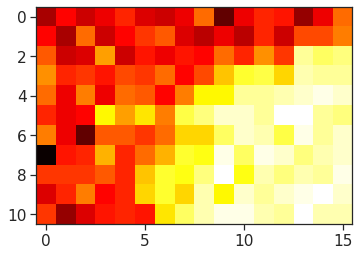

In [35]:
plt.imshow(ltable, cmap='hot', interpolation='nearest')
plt.show()

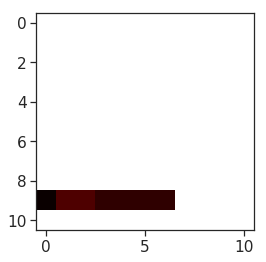

In [35]:
plt.imshow(dctable, cmap='hot', interpolation='nearest')
plt.show()

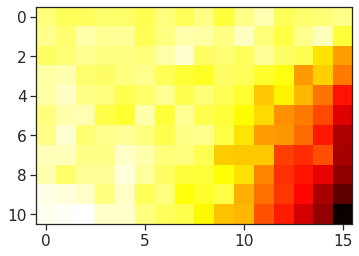

In [36]:
plt.imshow(rttable, cmap='hot', interpolation='nearest')
plt.show()

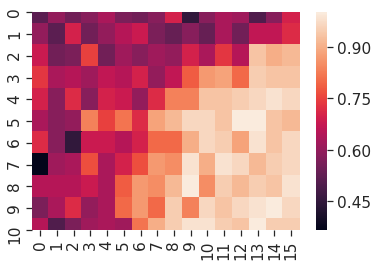

In [37]:
ax = sns.heatmap(ltable, linewidth=0)
plt.show()

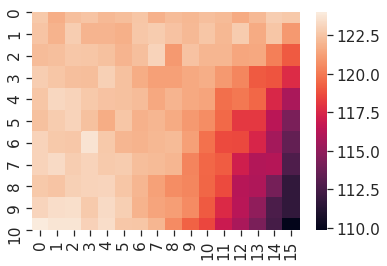

In [26]:
ax = sns.heatmap(rttable, linewidth=0)
plt.show()

In [247]:
rttable

[[7484.602759806315,
  7494.210583496094,
  7523.037482706705,
  7511.311189778646,
  7468.172350056966,
  7482.535758463541,
  7513.912823486328,
  7487.423387654622,
  7497.851712036133,
  7498.683051554362,
  7507.140586344401],
 [7491.125764973958,
  7480.7509073893225,
  7505.606788126627,
  7495.898876953125,
  7519.500185139974,
  7521.002133178711,
  7499.8666300455725,
  7532.514396158854,
  7528.076031494141,
  7490.107118733724,
  7493.328503417969],
 [7531.6297475179035,
  7511.230241902669,
  7521.302838134766,
  7509.76001180013,
  7497.549018351237,
  7524.088619995117,
  7533.313397216797,
  7514.631258138021,
  7505.656150309244,
  7512.1463490804035,
  7526.641272989908],
 [7528.226844278971,
  7533.014213053385,
  7540.886435953776,
  7528.912157185872,
  7518.383847045899,
  7533.864732869466,
  7536.166083780924,
  7520.219397989908,
  7529.3778605143225,
  7527.492479451497,
  7512.146547444661],
 [7548.444739786783,
  7539.170061238607,
  7527.29212137858,
  7552

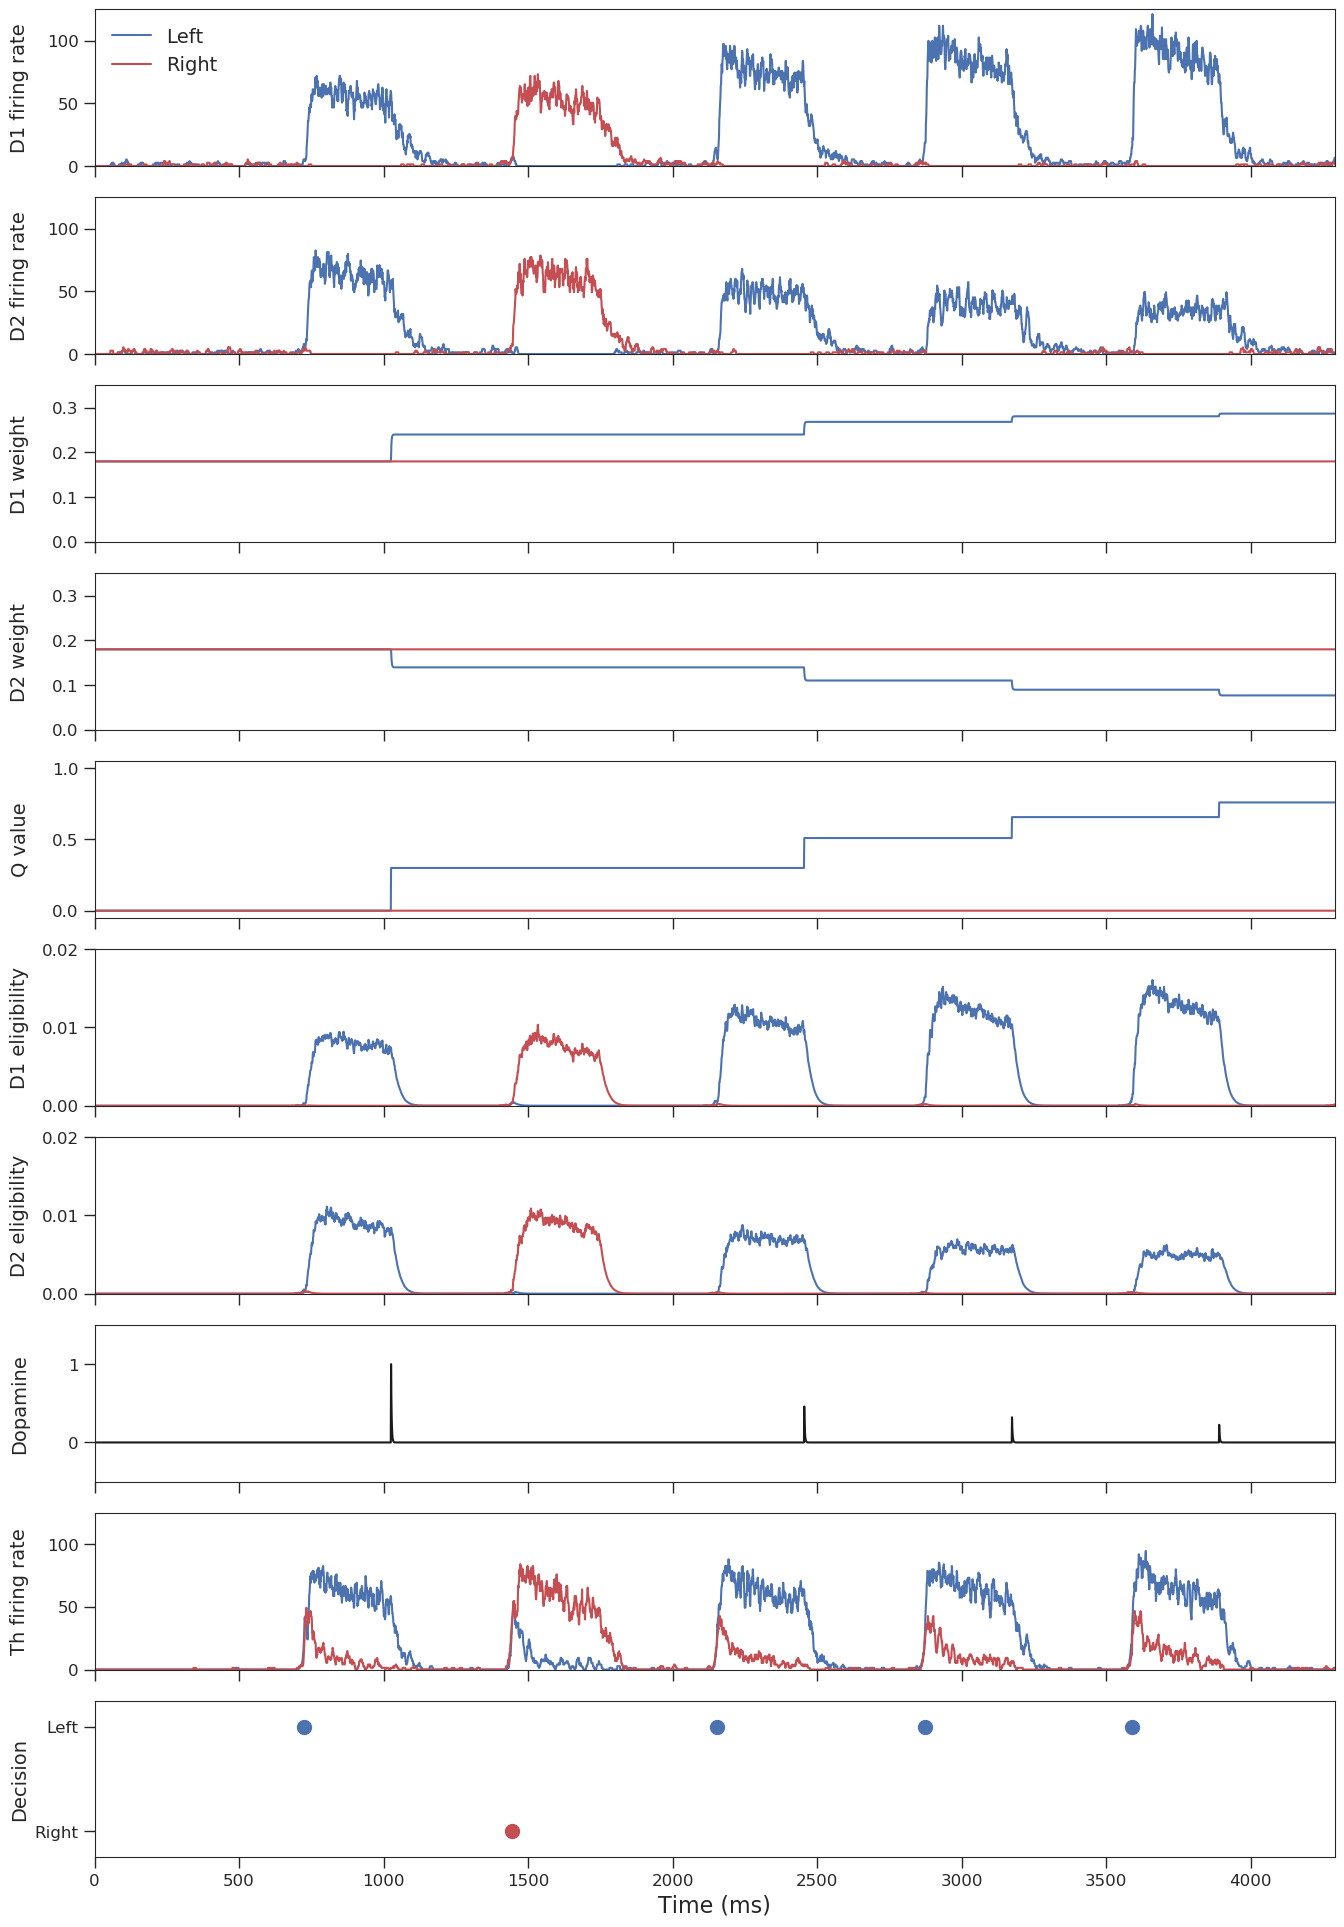

In [288]:
from cycler import cycler

sns.reset_orig()
sns.set_style("ticks")

plt.rcParams['axes.prop_cycle'] = cycler(color='brmrcmykg')

confignum = 4
repnum = 0

result = resultsB[confignum][repnum]

stagecount = len(decisionsB[confignum][repnum])
reacttimes = []
reactions = []
allreactions = []
for i in range(0, stagecount):
    if decisionsB[confignum][repnum][i]['pathvals'] != None and len(decisionsB[confignum][repnum][i]['pathvals']) > 0:
        reactions.append(1-decisionsB[confignum][repnum][i]['pathvals'][0])
    else:
        reactions.append(0.5)
    reacttimes.append(decisionsB[confignum][repnum][i]['time'])
#print(reactions)
#print('accuracy overal: ' + str(np.mean(reactions)))

f, (ax1, ax2, ax3, ax4, ax5, ax7, ax8, ax9, ax10, ax11) = plt.subplots(10, 1, figsize=(16,24), sharex=True)

#for i in range(0,result['dims']['choices']):
#    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1, title='D1 firing rate')
#    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2, title='D2 firing rate')
#    #result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax3, title='GPe firing rate')
#    #result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax4, title='STN firing rate')
#    result['popweights'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax3, title='D1 weight')
#    result['popweights'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax4, title='D2 weight')
#    #result['popQ1s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax5, title='Q1')
#    #result['popQ2s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax6, title='Q2')
#    result['popEs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax7, title='D1 eligibility')
#    result['popEs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax8, title='D2 eligibility')
#    result['dopamine'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax9, title='dopamine')
#    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax10, title='thalamus firing rate')

for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1)
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2)
    #result['popfreqs'].plot(x='Time (ms)', y='GPeP_'+str(i)+'_0', ax=ax3, title='GPe firing rate')
    #result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax4, title='STN firing rate')
    result['popweights'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax3)
    result['popweights'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax4)
    #result['popQ1s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax5, title='Q1')
    #result['popQ2s'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax6, title='Q2')
    result['popEs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax7)
    result['popEs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax8)
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax10)
    

#ax1.set_xlim(200, ax1.get_xlim()[-1])#(250,750)#(2500,2750)#(750,1200)#(750,1000)#(200, ax.get_xlim()[-1])#

#ax2.set_xlim(200, ax1.get_xlim()[-1])#(250,750)#(2500,2750)#(750,1200)#(750,1000)#(200, ax.get_xlim()[-1])#
#ax1.set_xlim(0, 1000)#(250,750)#
#ax2.set_xlim(0, 1000)#(250,750)#


result['dopamine'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax9, color='k')

result['popQ1s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)
result['popQ2s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)



#ax11.plot(reacttimes,reactions, marker='o', linestyle='None')

ax11.plot([reacttimes[i] for i in [0,2,3,4]],[reactions[i] for i in [0,2,3,4]], marker='o', linestyle='None', markersize=10)
ax11.plot([reacttimes[i] for i in [1]],[reactions[i] for i in [1]], marker='o', linestyle='None', markersize=10)
#ax11.plot(reacttimes,[None,0,None,None,None], marker='o', linestyle='None')
#ax11.set_title('Decision')
ax11.set_ylim(-0.25,1.25)
ax11.set_xlim(0,reacttimes[4]+700)

#ax1.set_ylim(0,10)

ax1.set_ylim(.0,125)
ax2.set_ylim(.0,125)
ax3.set_ylim(.0,.35)
ax4.set_ylim(.0,.35)
ax7.set_ylim(.0,.02)
ax8.set_ylim(.0,.02)
ax9.set_ylim(-.5,1.5)
ax10.set_ylim(0,125)
#ax4.set_ylim(-0.25,60)

#ax3.set_ylim(.995,1.0025)

#plt.savefig('/home/mclapp/Desktop/90_10_prob_feeback.png', dpi=400)
#plt.savefig('test.png', dpi=400)

labels = [item.get_text() for item in ax11.get_yticklabels()]
labels[1] = 'Right'
labels[2] = 'Left'
ax11.set_yticklabels(labels)

ax1.set_ylabel('D1 firing rate', fontsize=14)
ax2.set_ylabel('D2 firing rate', fontsize=14)
ax3.set_ylabel('D1 weight', fontsize=14)
ax4.set_ylabel('D2 weight', fontsize=14)
ax5.set_ylabel('Q value', fontsize=14)
ax7.set_ylabel('D1 eligibility', fontsize=14)
ax8.set_ylabel('D2 eligibility', fontsize=14)
ax9.set_ylabel('Dopamine', fontsize=14)
ax10.set_ylabel('Th firing rate', fontsize=14)
ax11.set_ylabel('Decision', fontsize=14)
f.align_ylabels()

ax11.set_xlabel("Time (ms)", fontsize=16)

ax1.legend(['Left','Right'],loc='upper left',fontsize=14,frameon=False)
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax7.get_legend().remove()
ax8.get_legend().remove()
ax9.get_legend().remove()
ax10.get_legend().remove()

f.set_facecolor('w')

ax1.tick_params(labelsize='large',width=1,length=8)
ax2.tick_params(labelsize='large',width=1,length=8)
ax3.tick_params(labelsize='large',width=1,length=8)
ax4.tick_params(labelsize='large',width=1,length=8)
ax5.tick_params(labelsize='large',width=1,length=8)
ax7.tick_params(labelsize='large',width=1,length=8)
ax8.tick_params(labelsize='large',width=1,length=8)
ax9.tick_params(labelsize='large',width=1,length=8)
ax10.tick_params(labelsize='large',width=1,length=8)
ax11.tick_params(labelsize='large',width=1,length=8)

ax7.locator_params(axis = 'y', nbins = 2)
ax8.locator_params(axis = 'y', nbins = 2)
ax9.locator_params(axis = 'y', nbins = 2)
ax11.locator_params(axis = 'y', nbins = 1)
plt.savefig("fig2.svg")

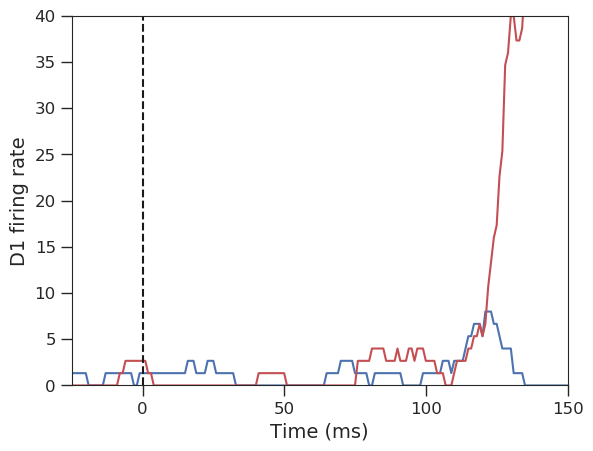

In [287]:
shiftedtime = result['popfreqs'].copy()
shiftedtime['Time (ms)'] = shiftedtime['Time (ms)'] - (reacttimes[0]+600)
f, (ax1) = plt.subplots(1, 1)
f.set_facecolor('w')
shiftedtime.plot(x='Time (ms)', y='D1STR_0_0', ax=ax1)
shiftedtime.plot(x='Time (ms)', y='D1STR_1_0', ax=ax1)
ax1.set_xlim(-25,150)
ax1.set_ylim(0,40)
ax1.get_legend().remove()
ax1.set_ylabel('D1 firing rate', fontsize=14)
ax1.set_xlabel('Time (ms)', fontsize=14)
ax1.axvline(0, color='k', linestyle='--')
ax1.tick_params(labelsize='large',width=1,length=8)
ax1.locator_params(axis = 'x', nbins = 4)
plt.savefig("fig3.svg")

In [239]:
reacttimes[0]+600

1326.02587890625

In [132]:
reacttimes[(0,1,2)]

TypeError: list indices must be integers or slices, not tuple

In [228]:
result

{'dims': {'brain': 1, 'choices': 2},
 'poppaths': {'FSI': ['brain'],
  'LIPI': ['brain'],
  'GPi': ['choices', 'brain'],
  'STNE': ['choices', 'brain'],
  'GPeP': ['choices', 'brain'],
  'D1STR': ['choices', 'brain'],
  'D2STR': ['choices', 'brain'],
  'LIP': ['choices', 'brain'],
  'Th': ['choices', 'brain']},
 'popcopylist': [{'name': 'FSI',
   'data': {'N': 75.0,
    'C': 0.2,
    'Taum': 10,
    'RestPot': -70,
    'ResetPot': -55,
    'Threshold': -50,
    'RestPot_ca': -85,
    'Alpha_ca': 0.5,
    'Tau_ca': 80,
    'Eff_ca': 0.0,
    'tauhm': 20,
    'tauhp': 100,
    'V_h': -60,
    'V_T': 120,
    'g_T': 0},
   'receptors': {'GABA': {'Tau': 5,
     'RevPot': -70,
     'FreqExt': 0,
     'FreqExtSD': 0,
     'MeanExtEff': 0,
     'MeanExtCon': 0},
    'AMPA': {'Tau': 2,
     'RevPot': 0,
     'FreqExt': 3.5999999999999996,
     'FreqExtSD': 0,
     'MeanExtEff': 1.55,
     'MeanExtCon': 800},
    'NMDA': {'Tau': 100,
     'RevPot': 0,
     'FreqExt': 0,
     'FreqExtSD': 0,
   

In [277]:
results[100][0]['dpmn_ratio']

0.9

In [279]:
results[100][0]['dpmn_implied']

2.0

In [140]:
for i in range(0,2):
    parentDir = 'cbgtDemoTEST17h'
    savedir = os.path.join(os.path.expanduser('~'), parentDir)
    saveTest=os.path.join(savedir, 'test')
    ng.setDirectory(saveTest)